# Reading 1D ecRad Output File

v3 2023-06-19:
- This version includes 3x3 matrix. 3 Optical Schemes for SW, LW and Total CRH

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
3. pysolar : 0.10
4. matplotlib : 3.6.2
5. scipy : 1.10.0

In [1]:
import os

import numpy as np
import xarray as xr
import pandas as pd
import scipy
from scipy import signal
from scipy import interpolate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

# Setting Font in Figures
#matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
#matplotlib.rcParams['font.family']     = 'sans-serif'

%matplotlib notebook

## Reading data

### ecRad output data

- 1O: Fu
- 2O: Baran2016
- 3O: Yi

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
ecrad_out_1O1S = xr.open_dataset(data_path+'output_1D_matrix_iwp_1O1S_v3.nc')
ecrad_out_2O1S = xr.open_dataset(data_path+'output_1D_matrix_iwp_2O1S_v3.nc')
ecrad_out_3O1S = xr.open_dataset(data_path+'output_1D_matrix_iwp_3O1S_v3.nc')

### Tropical Profile

In [3]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_69798/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [4]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_1O1S.pressure_hl.values)

In [5]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

### Cloud Heating Rate (CRH) matrix calculation:

In [6]:
rows = ecrad_out_1O1S.sizes['column'] # IWP
prof = ecrad_out_1O1S.sizes['half_level'] # Vertical Profile

## Heating rates matrices [K day-1]:
H_lw = np.zeros((3, rows, prof-1))
H_sw = np.zeros((3, rows, prof-1))
H    = np.zeros((3, rows, prof-1))

# Heat capacity [J kg-1 K-1]:
cp = 1.08*10**(3)
# Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
# Gravity [m s-2]:
g = 9.8

# Matrices for plotting:
H_sw_plot = np.zeros((3, prof-1, rows))
H_lw_plot = np.zeros((3, prof-1, rows))
H_plot    = np.zeros((3, prof-1, rows))

for j in range(3): # per optical scheme
    ecrad_out = eval('ecrad_out_'+str(j+1)+'O1S')
    for i in range(rows):
        pres = ecrad_out.pressure_hl.values[i] # Pressure [Pa]

        # Net Fluxes [W m-2]
        lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values[i] - ecrad_out.flux_up_lw.values[i]
        lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values[i] - ecrad_out.flux_up_lw_clear.values[i]
        sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values[i] - ecrad_out.flux_up_sw.values[i]
        sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values[i] - ecrad_out.flux_up_sw_clear.values[i]

        # Cloud Radiative Effect [W m-2]
        lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
        sw_cre = sw_net_flux_cloudy - sw_net_flux_clear

        # rad = pd.DataFrame({'pressure_hPa':pres*0.01,'lw_cre_Wm2':lw_cre,'sw_cre_Wm2':sw_cre})
        # rad = rad.set_index('pressure_hPa')
    
        H_lw[j,i,:] = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day-1
        H_sw[j,i,:] = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day-1

    H[j,:,:] = H_lw[j,:,:] + H_sw[j,:,:]
    
    # For plotting:
    H_sw_plot[j,:,:] = np.transpose(H_sw[j,:,:])
    H_lw_plot[j,:,:] = np.transpose(H_lw[j,:,:])
    H_plot[j,:,:]    = np.transpose(H[j,:,:])

#### Plotting CRH Matrix

In [14]:
temp

0     207.6000
1     207.1000
2     206.1000
3     205.1000
4     204.1000
        ...   
77    294.8375
78    296.3125
79    297.7875
80    299.2625
81    300.0000
Length: 82, dtype: float64

<IPython.core.display.Javascript object>


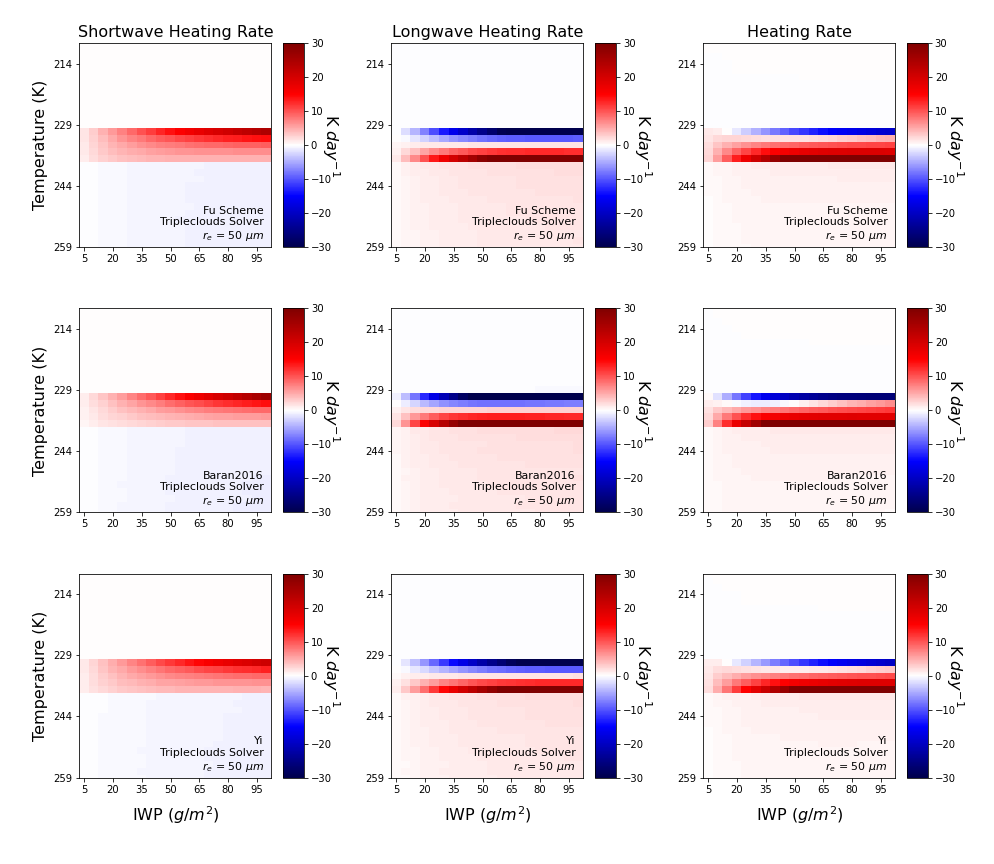

In [20]:
fontsize = 16
heigth   = 12 # inches
length   = heigth*1.15 # inches

rows = 3
columns = 3
f, ax = plt.subplots(rows, columns, figsize=(length,heigth), dpi=72)
plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.08, right = 0.95, 
                    hspace = .3, wspace = .3)

# COLORMAPS

for j in range(3):
    # Shortwave Heating Rate
    im = ax[j,0].imshow(H_sw_plot[j], cmap = "seismic", aspect = 'auto',
                      vmin = -30, vmax = 30)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.set_label(r'K $day^{-1}$', rotation = 270, labelpad = 10, 
                   fontsize = fontsize)
    if j ==0:
        ax[j,0].set_title('Shortwave Heating Rate', fontsize = fontsize, 
                        color = 'black')

    # Longwave Heating Rate
    im = ax[j,1].imshow(H_lw_plot[j], cmap = "seismic", aspect = 'auto', 
                      vmin = -30, vmax = 30)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.set_label(r'K $day^{-1}$', rotation = 270, labelpad = 10,
                   fontsize = fontsize)
    if j ==0:
        ax[j,1].set_title('Longwave Heating Rate', fontsize = fontsize,
                        color = 'black')

    # Heating Rate
    im = ax[j,2].imshow(H_plot[j], cmap = "seismic", aspect = 'auto',
                      vmin = -30, vmax = 30)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.set_label(r'K $day^{-1}$', rotation = 270, labelpad = 10,
                   fontsize = fontsize)
    if j ==0:
        ax[j,2].set_title('Heating Rate', fontsize = fontsize,
                        color ='black')




# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0,H.shape[2]+9,9) # altitude tick labels
yticklabels = temp.loc[yticks].astype('int').to_list()    
    
# X Axis:
iwp         = np.arange(5,105,5)
xticks      = np.arange(0,21,3)
xticklabels = iwp[xticks]#.astype('int').to_list()  

OptSch = ['Fu Scheme','Baran2016','Yi']
for j in range(3):
    for i in range(columns):
        # Horizontal Lines:
        h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
                          dashes = (3, 2), linewidth  =2)
        h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
                          dashes = (3, 2), linewidth  =2)
        if j==2:
            ax[j,i].set_xlabel(r'IWP $(g/m^2)$', fontsize = fontsize,
                             color ='black', labelpad = 10)
        ax[j,i].set_yticks(yticks)
        ax[j,i].set_yticklabels(yticklabels)
        ax[j,i].set_xticks(xticks)
        ax[j,i].set_xticklabels(xticklabels) #[::-1]
        ax[j,i].set_ylim((temp - 260).abs().argmin(),(temp - 210).abs().argmin())
        if i == 0:
            ax[j,i].set_ylabel('Temperature (K)', fontsize = fontsize,
                             color ='black', labelpad = 5)
        ax[j,i].text(0.96, 0.02, OptSch[j]+'\n'+'Tripleclouds Solver'+'\n'+r'$r_e$ = 50 $\mu m$',
                   ha = 'right', va = 'bottom', transform = ax[j,i].transAxes,
                   fontsize = fontsize - 5, color = 'black')


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
plt.savefig(out_dir+'1D_matrix_iwp_1S_v3.png', dpi=500)